# Section 5: Analyzing Candidate Plans

In [1]:
import sys
sys.path.append("../postbound/postbound")

In [2]:
from collections.abc import Iterable
from typing import Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

from postbound.db import db, postgres
from postbound.optimizer import jointree
from postbound.optimizer.policies import cardinalities
from postbound.experiments import workloads
from postbound.util import collections as collection_utils, jsonize

import analysis

In [3]:
results_base = "../datasets/02-plan-space"
static_results_base = "../datasets/00-base"
workloads.workloads_base_dir = "../postbound/workloads"
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
sns.set_style("whitegrid")
sns.set_context("talk")

## General definitions

In [4]:
job = workloads.job()
stats = workloads.stats()
(job, stats)

(Workload: JOB (113 queries), Workload: Stats (146 queries))

In [5]:
def load_df(workload: workloads.Workload, *, server: Literal["hdd", "ssd"]):
    df = pd.read_csv(f"{results_base}/plan-space-analysis-{workload.name.lower()}-{server}.csv",
                     converters={"query_plan": analysis.load_pg_explain})
    df["label"] = pd.Categorical(df["label"], categories=workload.labels(), ordered=True)
    df["estimated_cost"] = df["query_plan"].map(lambda plan: plan.explain_data["Plan"]["Total Cost"])
    df["plan_hash"] = df["query_plan"].map(hash)

    return df

In [6]:
df_job_hdd = load_df(job, server="hdd")

In [7]:
df_job_ssd = load_df(job, server="ssd")

In [8]:
df_stats_ssd = load_df(stats, server="ssd")

## Section 5.1: Correlation of Cost Estimates and Runtime

### Figure 6: Examples of join orders forming multiple clusters

In [9]:
def make_correlation_plot(df: pd.DataFrame, label: str, *, out:str,
                          corr_annot: tuple[float, float],
                          ticks: list[float], tick_labels: list[str]) -> None:
    samples = df.query("label == @label & ~timeout")
    corr_value = round(scipy.stats.pearsonr(samples["estimated_cost"], samples["runtime"]).statistic, 2)

    fig, ax = plt.subplots(figsize=(5, 3.6))
    g = sns.regplot(samples, x="estimated_cost", y="runtime",
                    scatter=True, scatter_kws={"edgecolors": "white"},
                    line_kws={"color": "grey"},
                    ax=ax)
    g.set_xscale("log", subs=[])
    g.set(xlabel="Estimated cost [log]", ylabel="Execution time [s]", xticks=ticks)
    if tick_labels:
        g.set_xticklabels(tick_labels)
    g.annotate("$r_{pearson} = " + str(corr_value) + "$", corr_annot)

    fig.tight_layout()
    fig.savefig(out)

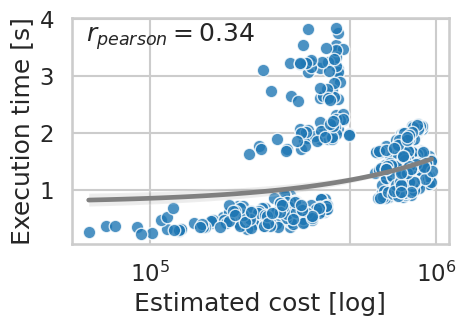

In [10]:
make_correlation_plot(df_job_ssd, "8b", out="plots/cost-runtime-corr-islands.pdf",
                      corr_annot=(0.6*10**5, 3.6),
                      ticks=[10**5, 5*10**5, 10**6],
                      tick_labels=[])

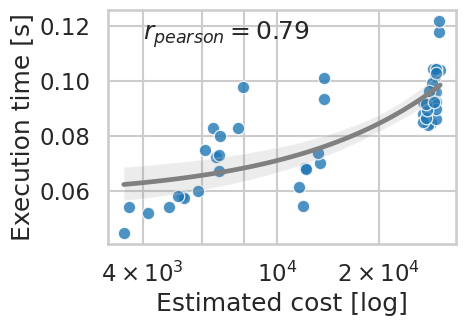

In [11]:
make_correlation_plot(df_stats_ssd, "q-45", out="plots/join-order-corr-stats-q-45.pdf",
                      corr_annot=(4*10**3, 0.115),
                      ticks=[4*10**3, 6*10**3, 8*10**3, 10**4, 2*10**4],
                      tick_labels=["$4 \\times 10^3$", "", "", "$10^4$", "$2 \\times 10^4$"])

### Prediction Error

In [12]:
def prediction_error(samples: pd.DataFrame) -> pd.Series:
    fit = scipy.stats.linregress(samples["estimated_cost"], samples["runtime"])
    prediction = fit.slope * samples["estimated_cost"] + fit.intercept
    error = np.abs(samples["runtime"] - prediction) / samples["runtime"]

    return pd.DataFrame({"predicted_runtime": prediction, "prediction_error": error}, index=samples.index)

def prediction_error_df(df: pd.DataFrame) -> pd.DataFrame:
    err_df = (df
              .query("~timeout")
              .groupby("label", as_index=False, observed=True)
              .apply(prediction_error, include_groups=False)
              .reset_index(level=1))

    return df.merge(err_df, left_index=True, right_on="level_1").drop(columns="level_1")


**(Mean, median) prediction error on JOB, HDD-server:**

In [13]:
errs_job_hdd = prediction_error_df(df_job_hdd)["prediction_error"]
errs_job_hdd.mean(), errs_job_hdd.median()

(np.float64(0.8561426466352385), np.float64(0.19471746030465642))

**(Mean, median) prediction error on JOB, SSD-server:**

In [14]:
errs_job_ssd = prediction_error_df(df_job_ssd)["prediction_error"]
errs_job_ssd.mean(), errs_job_ssd.median()

(np.float64(0.4532484684622855), np.float64(0.27332647977062474))

**(Mean, median) prediction error on Stats, SSD-server:**

In [15]:
errs_stats_ssd = prediction_error_df(df_stats_ssd)["prediction_error"]
errs_stats_ssd.mean(), errs_stats_ssd.median()

(np.float64(0.3634659705346531), np.float64(0.2144326113332021))

## Section 5.2: Importance of Base Join Selection

In [16]:
def lookup_base_joins(qep: db.QueryExecutionPlan | postgres.PostgresExplainPlan) -> set[db.QueryExecutionPlan]:
    qep = qep if isinstance(qep, db.QueryExecutionPlan) else qep.as_query_execution_plan()
    return {qep} if qep.is_base_join() else collection_utils.set_union(lookup_base_joins(child) for child in qep.children)


def make_base_join_df(df: pd.DataFrame) -> pd.DataFrame:
    df["base_join"] = df["query_plan"].map(lookup_base_joins).map(lambda joins: {frozenset(join.tables()) for join in joins})
    df = df.explode("base_join")
    df["join_label"] = df["base_join"].map(lambda join: " ⋈ ".join(tab.identifier() for tab in sorted(join)))
    return df

In [17]:
base_joins_job_hdd = make_base_join_df(df_job_hdd)
base_joins_job_ssd = make_base_join_df(df_job_ssd)
base_joins_stats_ssd = make_base_join_df(df_stats_ssd)

### Figure 7: Total plan runtime depending on the initial base join

In [18]:
def make_base_join_plot(df: pd.DataFrame, label: str, *, out: str, workload: str, server: str) -> None:
    current_samples = df.query("label == @label").sort_values(by="join_label")

    fig, ax = plt.subplots(figsize=(7, 4))
    g = sns.scatterplot(current_samples, x="runtime", y="join_label", ax=ax)
    g.set(xlabel="Plan runtime [s]", ylabel="Base join", title=f"{workload} query {label} ({server} server)")

    fig.tight_layout()
    fig.savefig(out)

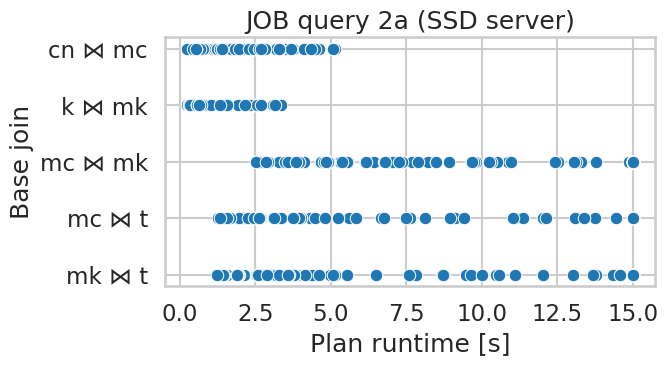

In [19]:
make_base_join_plot(base_joins_job_ssd, "2a", out="plots/base-tab-important.pdf", workload="JOB", server="SSD")

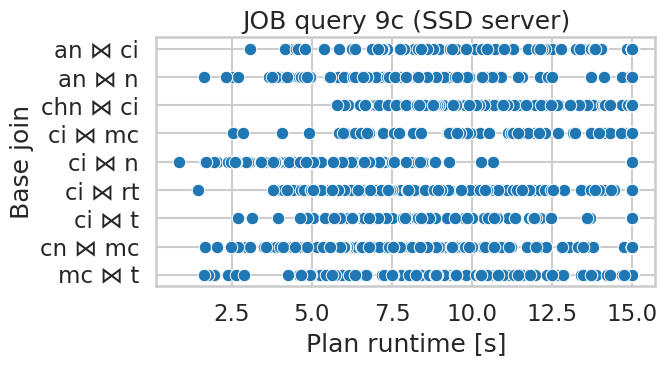

In [20]:
make_base_join_plot(base_joins_job_ssd, "9c", out="plots/base-tab-whatevs.pdf", workload="JOB", server="SSD")

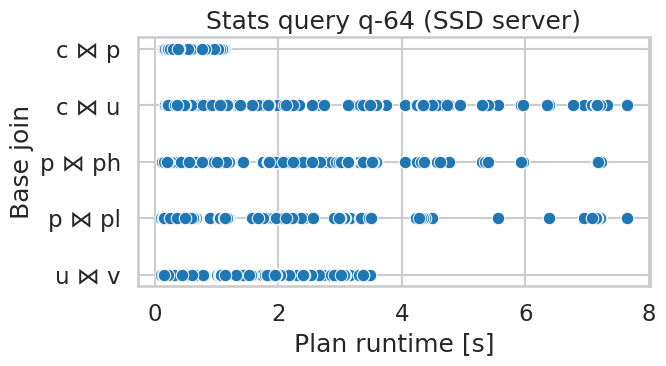

In [21]:
make_base_join_plot(base_joins_stats_ssd, "q-64", out="plots/stats-base-tab-important.pdf", workload="Stats", server="SSD")

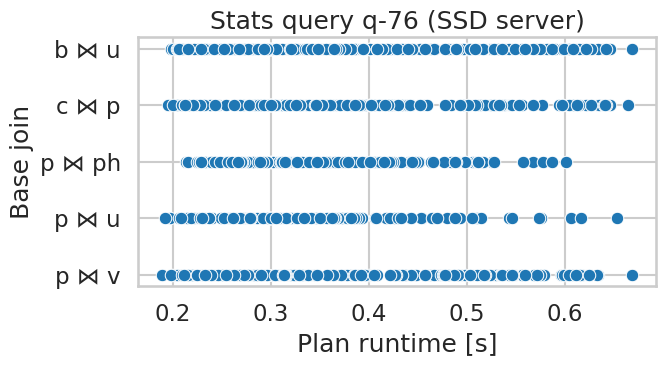

In [22]:
make_base_join_plot(base_joins_stats_ssd, "q-76", out="plots/stats-base-tab-whatev.pdf", workload="Stats", server="SSD")

###  Figure 8: Importance of base join selection for all queries of the JOB.

In [23]:
def make_importance_dfs(plan_df: pd.DataFrame, base_join_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:

    # First, compute the minimum/maximum runtimes and the top 25% threshold for each query
    rt_summary = (plan_df  # don't use base_join_df here, it contains duplicates which skew the quantile!
                  .groupby("label", as_index=False, observed=False)
                  .agg(min_rt=pd.NamedAgg(column="runtime", aggfunc="min"),
                       max_rt=pd.NamedAgg(column="runtime", aggfunc=lambda rts: rts.quantile(0.9)))
                  .assign(top25_rt=lambda sample: 0.75 * sample["min_rt"] + 0.25 * sample["max_rt"]))  # unrolled form: min + 0.25 * (max - min)

    # Now, determine how many of the execution plans are in the top 25% for each query
    top25_plans = (plan_df  # see comment above: never use base_join_df here
                   .merge(rt_summary, on="label")
                   .query("runtime <= top25_rt")
                   .groupby(["label", "top25_rt"], as_index=False, observed=True)  # top25_rt is dependent, we just carry it along
                   .size()
                   .rename(columns={"size": "total_top25_plans"}))

    # We are ready to compute the F1 score for each base join
    join_importance_df = (base_join_df
                          .merge(top25_plans, on="label")
                          .assign(top25_indicator=lambda sample: sample["runtime"] <= sample["top25_rt"])
                          .groupby(["label", "base_join", "join_label", "total_top25_plans"], as_index=False, observed=True)  # total_top25_plans is dependent, we just carry it along
                          .agg(base_join_plans=pd.NamedAgg(column="plan_hash", aggfunc="nunique"),                            # how many plans do we have for this base join? (Theoretically, we don't need to do nunique here since the plans should be unique anyway, but its more expressive..)
                               top25_plans=pd.NamedAgg(column="top25_indicator", aggfunc="sum"))                              # how many of these plans are in the top 25%?
                          .assign(precision=lambda sample: sample["top25_plans"] / sample["base_join_plans"],
                                  recall=lambda sample: sample["top25_plans"] / sample["total_top25_plans"],
                                  f1_score=lambda sample: 2 * sample["precision"] * sample["recall"] / (sample["precision"] + sample["recall"]))
                          .sort_values(by=["label", "join_label"]))

    # Prepare for the aggregated F1 scores: determine the weighting factor for each base join
    importance_weigths = (join_importance_df
                          .sort_values(by="f1_score", ascending=False)
                          .groupby("label", as_index=False, observed=True)
                          ["join_label"]
                          .transform(lambda sample: np.arange(len(sample)) + 1)
                          .to_frame()
                          .rename(columns={"join_label": "harmonic_weight"}))

    # Also, we will need to know which base join was actually the best for each query, so let's just compute this here as well
    max_f1s = (join_importance_df
               .assign(max_f1=(join_importance_df
                               .groupby("label", observed=True)
                               ["f1_score"]
                               .transform("max")))
               .query("f1_score == max_f1")
               .rename(columns={"base_join": "best_join"})
               [["label", "best_join"]])

    # Finally, all that's left to do is aggregate
    harmonic_importance = (join_importance_df
                           .merge(importance_weigths, left_index=True, right_index=True)
                           .merge(max_f1s, on="label")
                           .assign(f1_harmonic=lambda sample: 1 / sample["harmonic_weight"] * sample["f1_score"])
                           .groupby(["label", "best_join"], as_index=False, observed=True)
                           .agg(f1_harmonic=pd.NamedAgg(column="f1_harmonic", aggfunc="sum")))

    return join_importance_df, harmonic_importance


In [24]:
join_importance_job_ssd, harmonic_importance_job_ssd = make_importance_dfs(df_job_ssd, base_joins_job_ssd)
thresh = 0.75

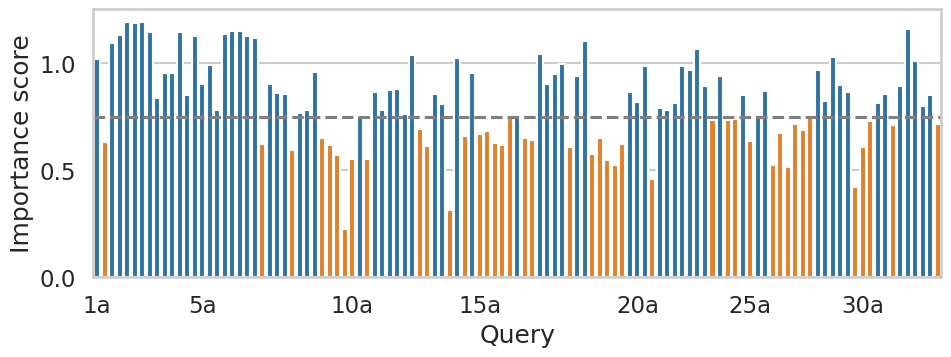

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.barplot(harmonic_importance_job_ssd.assign(relevant=harmonic_importance_job_ssd["f1_harmonic"] >= thresh),
                x="label", y="f1_harmonic",
                hue="relevant", hue_order=[True, False],
                ax=ax)
g.xaxis.set_ticks(job.labels())
g.axhline(thresh, color="grey", linestyle="dashed")
g.set_xticklabels([label if label.get_text()[-1] == "a" and ((int(label.get_text()[:-1]) % 5 == 0) or (i == 0)) else "" for i, label in enumerate(g.get_xticklabels())])
g.set(xlabel="Query", ylabel="Importance score")
g.legend().remove()
fig.tight_layout()
fig.savefig("plots/base-join-importance-ssd.pdf")

### Analysis of importance scores

**Number of JOB queries that exceed the importance threshold:**

In [26]:
len(harmonic_importance_job_ssd.query("f1_harmonic >= @thresh"))

71

**Is the base join with the highest score the one with the lowest cardinality?**

In [27]:
card_lookup_job = cardinalities.PreComputedCardinalities(job, f"{static_results_base}/intermediate-cards-job.csv")
card_lookup_stats = cardinalities.PreComputedCardinalities(stats, f"{static_results_base}/intermediate-cards-stats.csv")

def fetch_join_card(sample: pd.Series, *, workload: workloads.Workload, card_lookup: cardinalities.CardinalityHintsGenerator) -> float:
    query = workload[sample["label"]]
    join = frozenset(sample["base_join"])
    return card_lookup.calculate_estimate(query, join)

In [28]:
join_importance_job_ssd["join_card"] = join_importance_job_ssd.apply(fetch_join_card, axis="columns", workload=job, card_lookup=card_lookup_job)
join_importance_job_ssd["min_join_card"] = join_importance_job_ssd.groupby("label", observed=True)["join_card"].transform("min")


In [29]:
card_increase_job_ssd = join_importance_job_ssd.merge(harmonic_importance_job_ssd[["label", "best_join"]],
                                                      left_on=["label", "base_join"], right_on=["label", "best_join"])
card_increase_job_ssd["card_increase"] = (card_increase_job_ssd["join_card"] + 1) / (card_increase_job_ssd["min_join_card"] + 1)

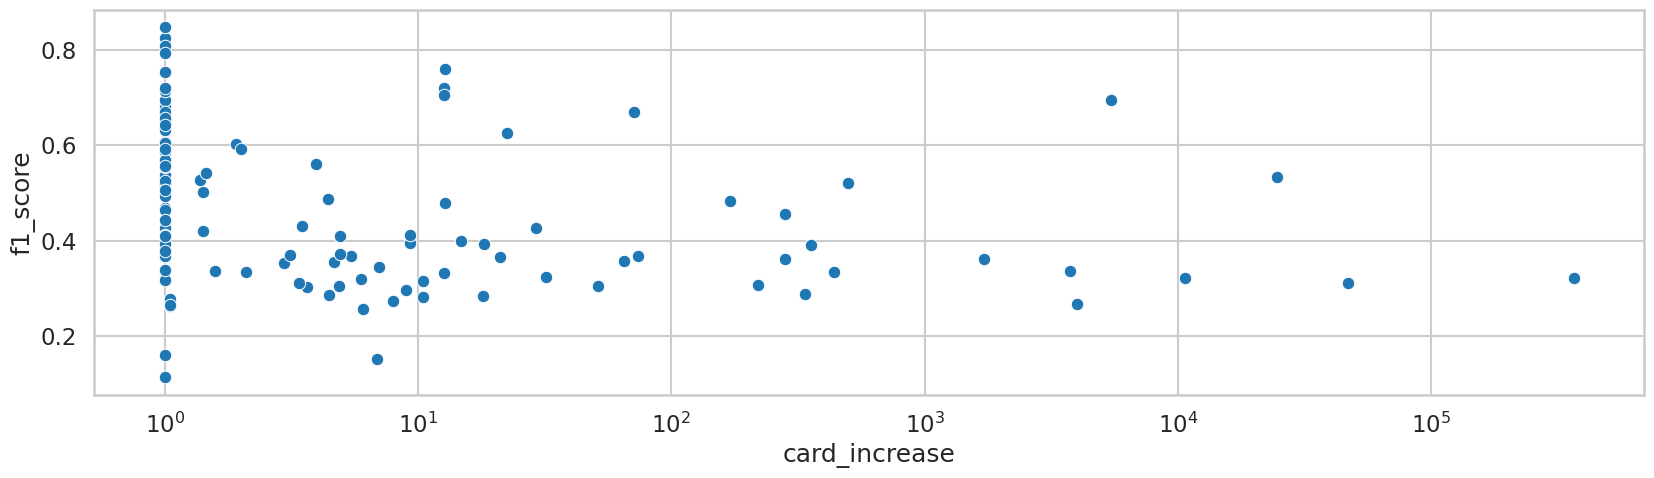

In [30]:
g = sns.scatterplot(card_increase_job_ssd, x="card_increase", y="f1_score")
g.set_xscale("log")

### Export best base join queries for resampling

In [31]:
resample_df = (harmonic_importance_job_ssd
    [harmonic_importance_job_ssd["f1_harmonic"] >= harmonic_importance_job_ssd["f1_harmonic"].quantile(0.9)]
    .sort_values(by="f1_harmonic", ascending=False)
    .assign(base_join=lambda sample: sample["best_join"].apply(jsonize.to_json)))

resample_df.to_csv("output/base-join-queries-f1.csv", index=False)
resample_df

,label,best_join,f1_harmonic,base_join
6,2c,"(movie_keyword AS mk, keyword AS k)",1.192498,"[{""full_name"": ""movie_keyword"", ""alias"": ""mk""}..."
4,2a,"(movie_keyword AS mk, keyword AS k)",1.192158,"[{""full_name"": ""movie_keyword"", ""alias"": ""mk""}..."
5,2b,"(movie_keyword AS mk, keyword AS k)",1.190415,"[{""full_name"": ""movie_keyword"", ""alias"": ""mk""}..."
108,32a,"(movie_keyword AS mk, keyword AS k)",1.159344,"[{""full_name"": ""movie_keyword"", ""alias"": ""mk""}..."
19,6c,"(movie_keyword AS mk, keyword AS k)",1.152976,"[{""full_name"": ""movie_keyword"", ""alias"": ""mk""}..."
18,6b,"(movie_keyword AS mk, keyword AS k)",1.152976,"[{""full_name"": ""movie_keyword"", ""alias"": ""mk""}..."
7,2d,"(movie_keyword AS mk, keyword AS k)",1.148726,"[{""full_name"": ""movie_keyword"", ""alias"": ""mk""}..."
11,4a,"(movie_keyword AS mk, keyword AS k)",1.145348,"[{""full_name"": ""movie_keyword"", ""alias"": ""mk""}..."
17,6a,"(name AS n, cast_info AS ci)",1.137778,"[{""full_name"": ""name"", ""alias"": ""n""}, {""full_n..."
3,1d,"(movie_info_idx AS mi_idx, info_type AS it)",1.130438,"[{""full_name"": ""movie_info_idx"", ""alias"": ""mi_..."


### Figure 9: Impact of imperfect cardinality estimates for non-base joins for queries with high base join importance

Please note that some erroneous data slipped through and ended up in the result data file. We have to clean this up first. Specifically, in some earlier analysis we repeated the same experiment with different queries. However, their plans have not been exported as JSON correctly. Since those queries do not possess significant importance scores anyway, we can safely ignore them.

In [32]:
flawed_df = pd.read_csv(f"{results_base}/imperfect-base-join-estimates-job-ssd.csv")
df_imperfect_ests = flawed_df[~flawed_df["query_plan"].str.startswith("EXPLAIN")].copy()
df_imperfect_ests["label"] = pd.Categorical(df_imperfect_ests["label"], categories=job.labels(), ordered=True)
df_imperfect_ests["query_plan"] = df_imperfect_ests["query_plan"].map(analysis.load_pg_explain)
df_imperfect_ests["join_order"] = df_imperfect_ests.apply(lambda sample: jointree.LogicalJoinTree.load_from_query_plan(sample["query_plan"].as_query_execution_plan(), query=job[sample["label"]]), axis="columns")
df_imperfect_ests

,label,runtime,timeout,query_plan,server,join_order
0,6c,2.265665,False,"EXPLAIN ANALYZE (plan time=0.203631, exec time...",ssd,(((k ⋈ mk) ⋈ ci) ⋈ t) ⋈ n
1,6c,3.257726,False,"EXPLAIN ANALYZE (plan time=0.191112, exec time...",ssd,(k ⋈ mk) ⋈ (n ⋈ (t ⋈ ci))
2,6c,3.258355,False,"EXPLAIN ANALYZE (plan time=0.191216, exec time...",ssd,(k ⋈ mk) ⋈ (n ⋈ (t ⋈ ci))
3,6c,1.499502,False,"EXPLAIN ANALYZE (plan time=0.191245, exec time...",ssd,(((k ⋈ mk) ⋈ ci) ⋈ t) ⋈ n
4,6c,1.564634,False,"EXPLAIN ANALYZE (plan time=0.191265, exec time...",ssd,(k ⋈ mk) ⋈ ((n ⋈ ci) ⋈ t)
...,...,...,...,...,...,...
2385,6b,4.350617,False,EXPLAIN ANALYZE (plan time=0.19191399999999997...,ssd,(n ⋈ (t ⋈ ci)) ⋈ (k ⋈ mk)
2386,6b,1.909363,False,EXPLAIN ANALYZE (plan time=0.19112600000000002...,ssd,(((k ⋈ mk) ⋈ t) ⋈ ci) ⋈ n
2387,6b,2.178604,False,"EXPLAIN ANALYZE (plan time=0.191089, exec time...",ssd,(n ⋈ ci) ⋈ ((k ⋈ mk) ⋈ t)
2388,6b,3.250516,False,"EXPLAIN ANALYZE (plan time=0.19104, exec time=...",ssd,(((k ⋈ mk) ⋈ ci) ⋈ t) ⋈ n


In [33]:
relevant_perfect_samples = df_job_ssd[df_job_ssd["label"].isin(resample_df["label"].unique())].copy()
relevant_perfect_samples["join_order"] = relevant_perfect_samples.apply(lambda sample: jointree.LogicalJoinTree.load_from_query_plan(sample["query_plan"].as_query_execution_plan(), query=job[sample["label"]]), axis="columns")
relevant_perfect_samples

,label,runtime,timeout,query_plan,server,estimated_cost,plan_hash,base_join,join_order
7844,32a,0.158845,False,EXPLAIN ANALYZE (plan time=0.00508900000000000...,ssd,150476.31,-3901646522231960367,"{(title AS t1, movie_link AS ml)}",k ⋈ (((t2 ⋈ (ml ⋈ t1)) ⋈ mk) ⋈ lt)
7845,32a,1.082320,False,EXPLAIN ANALYZE (plan time=0.00505999999999999...,ssd,92213.63,3189305175403154962,"{(movie_keyword AS mk, title AS t1)}",(t2 ⋈ ((ml ⋈ (t1 ⋈ mk)) ⋈ lt)) ⋈ k
7846,32a,0.129032,False,EXPLAIN ANALYZE (plan time=0.00526199999999999...,ssd,172449.41,2781225526815175211,"{(title AS t2, movie_link AS ml)}",k ⋈ (((t1 ⋈ (t2 ⋈ ml)) ⋈ mk) ⋈ lt)
7847,32a,0.127212,False,"EXPLAIN ANALYZE (plan time=0.005131, exec time...",ssd,173754.58,-5312413266931559022,"{(title AS t1, movie_link AS ml)}",k ⋈ (t2 ⋈ (((t1 ⋈ ml) ⋈ lt) ⋈ mk))
7848,32a,0.131096,False,EXPLAIN ANALYZE (plan time=0.00393699999999999...,ssd,173201.58,-196253959162287956,"{(link_type AS lt, movie_link AS ml)}",k ⋈ (t2 ⋈ ((t1 ⋈ (lt ⋈ ml)) ⋈ mk))
...,...,...,...,...,...,...,...,...,...
95943,6d,1.418842,False,"EXPLAIN ANALYZE (plan time=0.002472, exec time...",ssd,686844.59,-6606384908254353671,"{(name AS n, cast_info AS ci), (movie_keyword ...",((k ⋈ mk) ⋈ (n ⋈ ci)) ⋈ t
95944,6d,15.000000,True,EXPLAIN root: Aggregate(cost=8570827.6 rows=1),ssd,8570827.60,7256014613769914067,"{(movie_keyword AS mk, cast_info AS ci)}",(n ⋈ (t ⋈ (ci ⋈ mk))) ⋈ k
95945,6d,2.260727,False,EXPLAIN ANALYZE (plan time=0.00210000000000000...,ssd,306930.81,4462393118380644612,"{(title AS t, movie_keyword AS mk), (name AS n...",((n ⋈ ci) ⋈ (t ⋈ mk)) ⋈ k
95946,6d,15.000000,True,EXPLAIN root: Aggregate(cost=2189346.38 rows=1),ssd,2189346.38,-1149812391106450489,"{(movie_keyword AS mk, cast_info AS ci)}",((n ⋈ (ci ⋈ mk)) ⋈ t) ⋈ k


In [34]:
native_est_impact = pd.DataFrame()
for label in df_imperfect_ests["label"].unique():
    perfect_cards = relevant_perfect_samples.query("label == @label")
    imperfect_cards = df_imperfect_ests.query("label == @label")

    current_impact_df = pd.merge(perfect_cards[["label", "runtime", "join_order"]],
                                 imperfect_cards[["label", "runtime", "join_order"]],
                                 on=["label", "join_order"], suffixes=("_perf", "_nat"))
    native_est_impact = pd.concat([native_est_impact, current_impact_df], ignore_index=True)

native_est_impact.sort_values(by="label", inplace=True)
native_est_impact

,label,runtime_perf,join_order,runtime_nat
1875,1d,0.309122,(((it ⋈ mi_idx) ⋈ mc) ⋈ ct) ⋈ t,0.557585
1904,1d,0.952154,(it ⋈ mi_idx) ⋈ ((ct ⋈ mc) ⋈ t),0.692973
1905,1d,0.952154,(it ⋈ mi_idx) ⋈ ((ct ⋈ mc) ⋈ t),0.629282
1906,1d,0.952154,(it ⋈ mi_idx) ⋈ ((ct ⋈ mc) ⋈ t),0.683651
1907,1d,0.952154,(it ⋈ mi_idx) ⋈ ((ct ⋈ mc) ⋈ t),0.693340
...,...,...,...,...
5725,32a,0.133967,t2 ⋈ ((ml ⋈ lt) ⋈ ((k ⋈ mk) ⋈ t1)),0.062095
5726,32a,0.133967,t2 ⋈ ((ml ⋈ lt) ⋈ ((k ⋈ mk) ⋈ t1)),0.062670
5727,32a,0.561672,((t1 ⋈ (t2 ⋈ ml)) ⋈ lt) ⋈ (k ⋈ mk),0.532363
5713,32a,0.133967,t2 ⋈ ((ml ⋈ lt) ⋈ ((k ⋈ mk) ⋈ t1)),0.059884


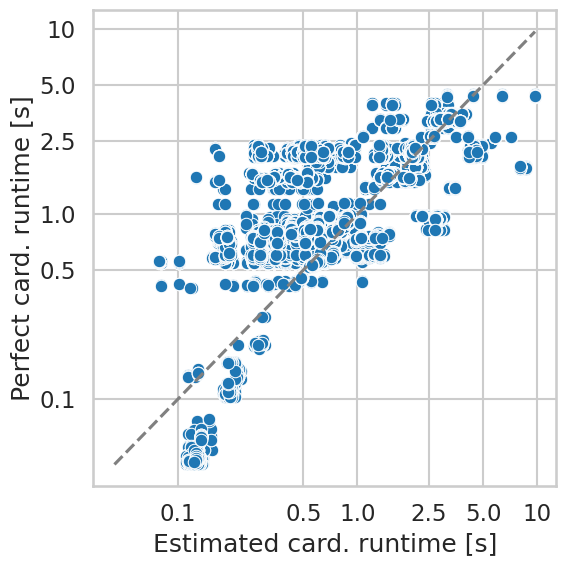

In [35]:
min_rt = native_est_impact[["runtime_nat", "runtime_perf"]].min().min()
max_rt = native_est_impact[["runtime_nat", "runtime_perf"]].max().max()

fig, ax = plt.subplots(figsize=(6,6))
ticks = [0.1, 0.5, 1.0, 2.5, 5.0, 10]

g = sns.scatterplot(native_est_impact,
                    x="runtime_perf", y="runtime_nat",
                    ax=ax)
g.plot([min_rt, max_rt], [min_rt, max_rt], color="grey", linestyle="dashed")
g.set_xscale("log")
g.set_yscale("log")
g.xaxis.set_ticks(ticks, labels=ticks)
g.yaxis.set_ticks(ticks, labels=ticks)
g.set(xlabel="Estimated card. runtime [s]", ylabel="Perfect card. runtime [s]")

fig.tight_layout()
fig.savefig("plots/base-join-imperfect-slowdown.pdf")